# Regression in PySpark's MLlib Project

Now it's time to put what you've learned to into action with a REAL project! 

You have been hired as a consultant to a cement production company who wants to be able to improve their customer experience around a number of areas like being able to provide recommendations to cusomters on optimal amounts of certian ingredients in the cement making process and perhaps even create an application where users can input their own values and received a predicted cement strength!

I have provided a list of question below to help guide you through this project but feel free to deviate and make this project your own! But first, a bit about this dataset.

### About this dataset 
This dataset contains 1030 instances of concrete samples, containing 9 attributes (8 continuous and 1 discreate), and 1 continuous quantitative output variable. There are no missing attribute values.

I've also provided the variable name, variable type, the measurement unit and a brief description of each variable in the dataset. The concrete compressive strength is the outcome variable for our analysis. The order of this listing corresponds to the order of numerals along the rows of the database.

Name -- Data Type -- Measurement -- Description

- Cement -- quantitative -- kg in a m3 mixture -- Input Variable 
- Blast Furnace Slag -- quantitative -- kg in a m3 mixture -- Input Variable 
- Fly Ash -- quantitative -- kg in a m3 mixture -- Input Variable 
- Water -- quantitative -- kg in a m3 mixture -- Input Variable 
- Superplasticizer -- quantitative -- kg in a m3 mixture -- Input Variable 
- Coarse Aggregate -- quantitative -- kg in a m3 mixture -- Input Variable 
- Fine Aggregate -- quantitative -- kg in a m3 mixture -- Input Variable 
- Age -- quantitative -- Day (1~365) -- Input Variable 
- Concrete compressive strength -- quantitative -- MPa -- Output Variable

**Source:** https://www.kaggle.com/maajdl/yeh-concret-data

**Dataset Name:** Concrete_Data.csv

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
# Install pyspark
!pip install pyspark
# import findspark
# findspark.init()
import os
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
# May take awhile locally
spark = SparkSession.builder.appName("Regression").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 20.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=4b0aac0e67ae0879e5d1faf0112ed1cecc02b7c9acd1fb155341c142b83bcd18
  Stored in directory: /root/.cache/pip/wheels/b1/59/a0/a1a0624b5e865fd389919c1a10f53aec9b12195d6747710baf
Successfully built pyspark
You are working with 1 core(s)


In [3]:
import pandas as pd
import numpy as np
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import * 
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import MinMaxScaler
# Dependencies for this section
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

### Read The Data

In [5]:
path = '/content/drive/MyDrive/Data Science Intake43/5. Spark/spark-scripts/section3/Datasets/'
os.listdir(path)

['beatsdataset.csv',
 'kickstarter.csv',
 'housing.csv',
 'fake_job_postings.csv',
 'Toddler Autism dataset July 2018.csv',
 'Concrete_Data.csv']

In [6]:
# path ="Datasets/"
df = spark.read.csv(path+'Concrete_Data.csv',inferSchema=True,header=True)
print((df.count(), len(df.columns)))

(1030, 9)


In [7]:
df.limit(6).toPandas()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03


In [8]:
df.printSchema()

root
 |-- cement: double (nullable = true)
 |-- slag: double (nullable = true)
 |-- flyash: double (nullable = true)
 |-- water: double (nullable = true)
 |-- superplasticizer: double (nullable = true)
 |-- coarseaggregate: double (nullable = true)
 |-- fineaggregate: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- csMPa: double (nullable = true)



In [9]:
df.columns

['cement',
 'slag',
 'flyash',
 'water',
 'superplasticizer',
 'coarseaggregate',
 'fineaggregate',
 'age',
 'csMPa']

In [10]:
# no nans
df.na.drop().count()-df.count()

0

In [11]:
df = df.na.drop()

## 1. Which features are the strongest predictors of cement strength?

Build your own ML model to figure this one out! This would be good information to give to our client so the sales reps can focus their efforts on certian ingredients to provide recommendations on. For example, if our clients had a customer that was struggling with their cement breaking, we could trouble shoot with them by starting with the factors that we know are important. 

In [12]:
def MLRegressDFPrep(df,input_columns,dependent_var,treat_outliers=True):

    renamed = df.withColumnRenamed(dependent_var,'label')
    
    # Make sure dependent variable is numeric and change if it's not
    if str(renamed.schema['label'].dataType) != 'IntegerType':
        renamed = renamed.withColumn("label", renamed["label"].cast(FloatType()))
    
   # Convert all string type data in the input column list to numeric
    # Otherwise the Algorithm will not be able to process it
    numeric_inputs = []
    string_inputs = []
    for column in input_columns:
        if str(renamed.schema[column].dataType) == 'StringType':
            new_col_name = column+"_num"
            string_inputs.append(new_col_name)
        else:
            numeric_inputs.append(column)
            indexed = renamed
            
    if len(string_inputs) != 0: # If the datafraem contains string types
        for column in input_columns:
            if str(renamed.schema[column].dataType) == 'StringType':
                indexer = StringIndexer(inputCol=column, outputCol=column+"_num") 
                indexed = indexer.fit(renamed).transform(renamed)
    else:
        indexed = renamed
        
            
    if treat_outliers == True:
        print("We are correcting for non normality now!")
        # empty dictionary d
        d = {}
        # Create a dictionary of quantiles
        for col in numeric_inputs: 
            d[col] = indexed.approxQuantile(col,[0.01,0.99],0.25) #if you want to make it go faster increase the last number
        #Now fill in the values
        for col in numeric_inputs:
            skew = indexed.agg(skewness(indexed[col])).collect() #check for skewness
            skew = skew[0][0]
            # This function will floor, cap and then log+1 (just in case there are 0 values)
            if skew > 1:
                indexed = indexed.withColumn(col, \
                log(when(df[col] < d[col][0],d[col][0])\
                .when(indexed[col] > d[col][1], d[col][1])\
                .otherwise(indexed[col] ) +1).alias(col))
                print(col+" has been treated for positive (right) skewness. (skew =)",skew,")")
            elif skew < -1:
                indexed = indexed.withColumn(col, \
                exp(when(df[col] < d[col][0],d[col][0])\
                .when(indexed[col] > d[col][1], d[col][1])\
                .otherwise(indexed[col] )).alias(col))
                print(col+" has been treated for negative (left) skewness. (skew =",skew,")")
                
    # Vectorize your features
    features_list = numeric_inputs + string_inputs
    assembler = VectorAssembler(inputCols=features_list,outputCol='features')
    final_data = assembler.transform(indexed).select('features','label')
        
    return final_data

In [13]:
input_columns = df.columns[:-1]
dependent_var = df.columns[-1]
input_columns


['cement',
 'slag',
 'flyash',
 'water',
 'superplasticizer',
 'coarseaggregate',
 'fineaggregate',
 'age']

In [14]:
dependent_var

'csMPa'

### Apply the preprocessing pipeline to the data

In [17]:
final_data = MLRegressDFPrep(df,input_columns,dependent_var)
final_data.show(5)

We are correcting for non normality now!
age has been treated for positive (right) skewness. (skew =) 3.2644145354168086 )
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[540.0,0.0,0.0,16...|79.99|
|[540.0,0.0,0.0,16...|61.89|
|[332.5,142.5,0.0,...|40.27|
|[332.5,142.5,0.0,...|41.05|
|[198.6,132.4,0.0,...| 44.3|
+--------------------+-----+
only showing top 5 rows



## Calculate the correlation between the features

In [18]:
from pyspark.ml.stat import Correlation
pearsonCorr = Correlation.corr(final_data, 'features', 'pearson').collect()[0][0]
array = pearsonCorr.toArray()

In [19]:
array

array([[ 1.        , -0.27521591, -0.39746734, -0.08158675,  0.09238617,
        -0.10934899, -0.22271785,  0.00333903],
       [-0.27521591,  1.        , -0.3235799 ,  0.10725203,  0.04327042,
        -0.28399861, -0.28160267, -0.02088054],
       [-0.39746734, -0.3235799 ,  1.        , -0.25698402,  0.37750315,
        -0.00996083,  0.07910849, -0.01974459],
       [-0.08158675,  0.10725203, -0.25698402,  1.        , -0.65753291,
        -0.1822936 , -0.45066117,  0.17021254],
       [ 0.09238617,  0.04327042,  0.37750315, -0.65753291,  1.        ,
        -0.26599915,  0.22269123, -0.04845305],
       [-0.10934899, -0.28399861, -0.00996083, -0.1822936 , -0.26599915,
         1.        , -0.17848096, -0.03813431],
       [-0.22271785, -0.28160267,  0.07910849, -0.45066117,  0.22269123,
        -0.17848096,  1.        , -0.1148533 ],
       [ 0.00333903, -0.02088054, -0.01974459,  0.17021254, -0.04845305,
        -0.03813431, -0.1148533 ,  1.        ]])

In [20]:
array.shape

(8, 8)

In [21]:
corr = pd.DataFrame(array)
corr

,0,1,2,3,4,5,6,7
0,1.000000,-0.275216,-0.397467,-0.081587,0.092386,-0.109349,-0.222718,0.003339
1,-0.275216,1.000000,-0.323580,0.107252,0.043270,-0.283999,-0.281603,-0.020881
2,-0.397467,-0.323580,1.000000,-0.256984,0.377503,-0.009961,0.079108,-0.019745
3,-0.081587,0.107252,-0.256984,1.000000,-0.657533,-0.182294,-0.450661,0.170213
4,0.092386,0.043270,0.377503,-0.657533,1.000000,-0.265999,0.222691,-0.048453
5,-0.109349,-0.283999,-0.009961,-0.182294,-0.265999,1.000000,-0.178481,-0.038134
6,-0.222718,-0.281603,0.079108,-0.450661,0.222691,-0.178481,1.000000,-0.114853
7,0.003339,-0.020881,-0.019745,0.170213,-0.048453,-0.038134,-0.114853,1.000000


### Heatmap of the correlation

#### Features 3,4 are strongly negatively correlated
#### Features 3,6 are moderately negatively correlated

<AxesSubplot:>

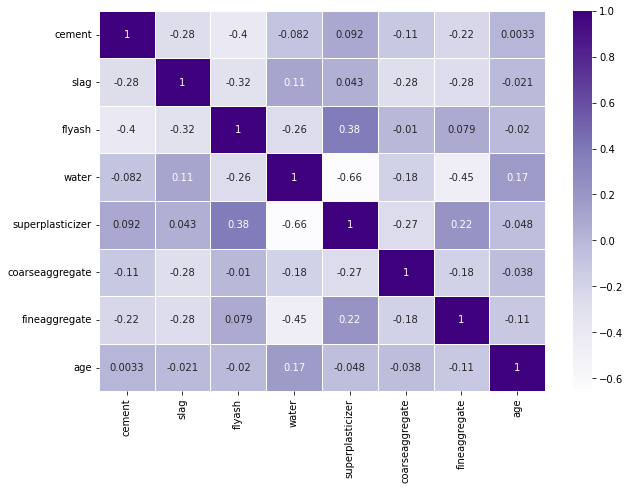

In [46]:
plt.figure(figsize=(10,7))
sns.heatmap(corr, cmap='Purples', linewidths=0.5, annot=True, yticklabels=input_columns, xticklabels= input_columns)
# Features 3,4 are strongly negatively correlated
# Features 3,6 are moderately negatively correlated
# No other significant (<0.5) correlation 

### Split the data and feed it to the model

In [23]:
train,test = final_data.randomSplit([0.7,0.3])

#### Train first on a base model

In [24]:
# Fit our model
regressor = LinearRegression()
fitModel = regressor.fit(train)
# Make predictions.
predictions = fitModel.transform(test)
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 6.9508


In [25]:
def RegressTrainEval(regressor):

    def FindMtype(regressor):
        # Intstantiate Model
        M = regressor
        # Learn what it is
        Mtype = type(M).__name__
        
        return Mtype
    
    Mtype = FindMtype(regressor)
#     print('\033[1m' + Mtype + ':' + '\033[0m')


    if Mtype == "LinearRegression":
        
        #first without cross val
        fitModel = regressor.fit(train)

        # Load the Summary
        trainingSummary = fitModel.summary
        
        # Print the coefficients and intercept for linear regression
        print('\033[1m' + "Linear Regression Model Training Summary without cross validation:"+ '\033[0m')
        print(" ")
        print("Intercept: %s" % str(fitModel.intercept))
        print("")
        print("Coefficients: ")
        coeff_array = fitModel.coefficients.toArray()
        # Convert from numpy array to list
        coeff_list = []
        for x in coeff_array:
            coeff_list.append(float(x))
        result = spark.createDataFrame(zip(input_columns,coeff_list), schema=['feature','coeff'])
        print(result.orderBy(result["coeff"].desc()).show(truncate=False))



        # Summarize the model over the training set and print out some metrics
        print("numIterations: %d" % trainingSummary.totalIterations)
        print("objectiveHistory: (scaled loss + regularization) at each iteration \n %s" % str(trainingSummary.objectiveHistory))
        print("")
        
        # Print the Errors
        print("Training RMSE: %f" % trainingSummary.rootMeanSquaredError)
        print("Training r2: %f" % trainingSummary.r2)
        print("")
        

        # Now load the test results
        test_results = fitModel.evaluate(test)

        # And print them
        print("Test RMSE: {}".format(test_results.rootMeanSquaredError))
        print("Test r2: {}".format(test_results.r2))
        print("")
        
        #Now train with cross val
        paramGrid = (ParamGridBuilder() \
#              .addGrid(regressor.maxIter, [10, 15]) \
             .addGrid(regressor.regParam, [0.1, 0.01]) \
             .build())
        
        #Evaluator
        revaluator = RegressionEvaluator(metricName="rmse")
        
        #Cross Validator requires all of the following parameters:
        crossval = CrossValidator(estimator=regressor,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=revaluator,
                                  numFolds=2) # 3 is best practice
        
        print('\033[1m' + "Linear Regression Model Summary WITH cross validation:"+ '\033[0m')
        print(" ")
        # Run cross validations
        fitModel = crossval.fit(train)
        
        #save model
        global LR_BestModel 
        LR_BestModel = fitModel.bestModel
        
        print("Coefficients: ")
        coeff_array = LR_BestModel.coefficients.toArray()
        # Convert from numpy array to list
        coeff_list = []
        for x in coeff_array:
            coeff_list.append(float(x))
        result = spark.createDataFrame(zip(input_columns,coeff_list), schema=['feature','coeff'])
        print(result.orderBy(result["coeff"].desc()).show(truncate=False))
        
        # Get Model Summary Statistics
        ModelSummary = fitModel.bestModel.summary
        
        print("Coefficient Standard Errors: ")
        coeff_ste = ModelSummary.coefficientStandardErrors
        result = spark.createDataFrame(zip(input_columns,coeff_ste), schema=['feature','coeff std error'])
        print(result.orderBy(result["coeff std error"].desc()).show(truncate=False))
        print(" ")
        print("P Values: ") 
        # Then zip with input_columns list and create a df
        pvalues = ModelSummary.pValues
        result = spark.createDataFrame(zip(input_columns,pvalues), schema=['feature','P-Value'])
        print(result.orderBy(result["P-Value"].desc()).show(truncate=False))
        print(" ")
        
        # Use test set here so we can measure the accuracy of our model on new data
        ModelPredictions = fitModel.transform(test)
        
        # cvModel uses the best model found from the Cross Validation
        # Evaluate best model
        test_results = revaluator.evaluate(ModelPredictions)
        print('RMSE:', test_results)
    
        # Set the column names to match the external results dataframe that we will join with later:
        columns = ['Regressor', 'Result']
        
        # Format results and return
        rmse_str = [str(test_results)] #make this a string and convert to a list
        Mtype = [Mtype] #make this a string
        result = spark.createDataFrame(zip(Mtype,rmse_str), schema=columns)
        result = result.withColumn('Result',result.Result.substr(0, 5))
        return result

    else:

        # Add parameters of your choice here:
        if Mtype in("RandomForestRegressor"):
            paramGrid = (ParamGridBuilder() \
#                            .addGrid(regressor.maxDepth, [2, 5, 10])
#                            .addGrid(regressor.maxBins, [5, 10, 20])
                           .addGrid(regressor.numTrees, [5, 20])
                         .build())

        # Add parameters of your choice here:
        if Mtype in("GBTRegressor"):
            paramGrid = (ParamGridBuilder() \
#                          .addGrid(regressor.maxDepth, [2, 5, 10, 20, 30]) \
                         .addGrid(regressor.maxBins, [10, 20]) \
                         .addGrid(regressor.maxIter, [10, 15])
                         .build())

        # Add parameters of your choice here:
        if Mtype in("DecisionTreeRegressor"):
            paramGrid = (ParamGridBuilder() \
#                          .addGrid(regressor.maxDepth, [2, 5, 10, 20, 30]) \
                         .addGrid(regressor.maxBins, [10, 20, 40]) \
                         .build())

        #Cross Validator requires all of the following parameters:
        crossval = CrossValidator(estimator=regressor,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=RegressionEvaluator(metricName="rmse"),
                                  numFolds=2) # 3 is best practice
        # Fit Model: Run cross-validation, and choose the best set of parameters.
        fitModel = crossval.fit(train)
        
        # Get Best Model
        BestModel = fitModel.bestModel

        # FEATURE IMPORTANCES
        # Estimate of the importance of each feature.
        # Each feature’s importance is the average of its importance across all trees 
        # in the ensemble The importance vector is normalized to sum to 1. 
        print(" ")
        print('\033[1m' + Mtype," Feature Importances"+ '\033[0m')
        print("(Scores add up to 1)")
        print("Lowest score is the least important")
        print(" ")
        featureImportances = BestModel.featureImportances.toArray()
        # Convert from numpy array to list
        imp_scores = []
        for x in featureImportances:
            imp_scores.append(float(x))
        # Then zip with input_columns list and create a df
        result = spark.createDataFrame(zip(input_columns,imp_scores), schema=['feature','score'])
        print(result.orderBy(result["score"].desc()).show(truncate=False))
        
        #Create Global Variables for feature importances and models
        if Mtype in("DecisionTreeRegressor"):
            global DT_featureImportances
            DT_featureImportances = BestModel.featureImportances.toArray()
            global DT_BestModel 
            DT_BestModel = fitModel.bestModel
        if Mtype in("GBTRegressor"):
            global GBT_featureImportances
            GBT_featureImportances = BestModel.featureImportances.toArray()
            global GBT_BestModel 
            GBT_BestModel = fitModel.bestModel
        if Mtype in("RandomForestRegressor"):
            global RF_featureImportances
            RF_featureImportances = BestModel.featureImportances.toArray()
            global RF_BestModel 
            RF_BestModel = fitModel.bestModel
                    
        # Set the column names to match the external results dataframe that we will join with later:
        columns = ['Regressor', 'Result']
        
        # Make predictions.
        predictions = fitModel.transform(test)
        # Select (prediction, true label) and compute test error
        evaluator = RegressionEvaluator(metricName="rmse")
        rmse = evaluator.evaluate(predictions)
        rmse_str = [str(rmse)] #make this a string and convert to a list
        Mtype = [Mtype] #make this a string
        result = spark.createDataFrame(zip(Mtype,rmse_str), schema=columns)
        # Clean up the Result column and output
        result = result.withColumn('Result',result.Result.substr(0, 5))
        return result

### Train the data on all the models

In [26]:
# Run!
regressors = [
                LinearRegression()
                ,DecisionTreeRegressor()
                ,RandomForestRegressor()
                ,GBTRegressor()
                ] 
    
#set up your results table
columns = ['Regressor', 'Result']
vals = [("Place Holder","N/A")]
results = spark.createDataFrame(vals, columns)

for regressor in regressors:
    new_result = RegressTrainEval(regressor)
    results = results.union(new_result)
results = results.where("Regressor!='Place Holder'")
results.show(100,False)

Linear Regression Model Training Summary without cross validation:
 
Intercept: -69.8660293056435

Coefficients: 
+----------------+--------------------+
|feature         |coeff               |
+----------------+--------------------+
|age             |9.490649236585538   |
|cement          |0.1342272494608525  |
|superplasticizer|0.11646853415740907 |
|slag            |0.11393176971519159 |
|flyash          |0.09464006890681298 |
|fineaggregate   |0.03194117478861043 |
|coarseaggregate |0.025131355815128178|
|water           |-0.1425550621873744 |
+----------------+--------------------+

None
numIterations: 0
objectiveHistory: (scaled loss + regularization) at each iteration 
 [0.0]

Training RMSE: 7.283358
Training r2: 0.817144

Test RMSE: 6.950803083145685
Test r2: 0.8080554181539502

Linear Regression Model Summary WITH cross validation:
 
Coefficients: 
+----------------+--------------------+
|feature         |coeff               |
+----------------+--------------------+
|age      

In [27]:
# Best model is the model with least rmes:
results.orderBy('Result').show(1, False)

+----------------+------+
|Regressor       |Result|
+----------------+------+
|LinearRegression|6.950 |
+----------------+------+
only showing top 1 row



## Results:
1. GBT Regressor performed the least RMSE of nearly 6.6
2. Each models save the importance of each feature in a global var named model_featureImportances (e.g. DT_featureImportances)

## Extract the most 5 importanat features of each model

In [43]:
input_columns

['cement',
 'slag',
 'flyash',
 'water',
 'superplasticizer',
 'coarseaggregate',
 'fineaggregate',
 'age']

In [40]:
print("Random Forest best features: ", )
best = RF_featureImportances.argsort()[-5:][::-1].astype(int)
print(np.array(input_columns)[best])

Random Forest best features: 
['age' 'cement' 'water' 'superplasticizer' 'slag']


In [41]:
print("GBT best features: ")
best = GBT_featureImportances.argsort()[-5:][::-1]
print(np.array(input_columns)[best])

GBT best features: 
['age' 'cement' 'water' 'slag' 'coarseaggregate']


In [44]:
print("Decision Tree best features: ")
best = DT_featureImportances.argsort()[-5:][::-1]
print(np.array(input_columns)[best])

Decision Tree best features: 
['age' 'cement' 'water' 'slag' 'superplasticizer']


## Accordingly, it's kinda agreed that (age, cement, water, slag) are the most important features

## 2. For the following given inputs, what would be the estimated cement strength?

- Cement: 540
- Blast Furnace Slag: 0
- Fly Ash: 0
- Water: 162
- Superplasticizer: 2.5
- Coarse Aggregate: 1040
- Fine Aggregate: 676
- Age: 28

The correct answer is 79.99. Let's how close your prediction is!

### Make a new DF with the same columns but only one observation

In [48]:
inputs = spark.createDataFrame([(540, 0.0, 0.0, 162, 2.5, 1040, 676, 28)], input_columns)
inputs.limit(5).toPandas()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age
0,540,0.0,0.0,162,2.5,1040,676,28


In [49]:
inputs.printSchema()

root
 |-- cement: long (nullable = true)
 |-- slag: double (nullable = true)
 |-- flyash: double (nullable = true)
 |-- water: long (nullable = true)
 |-- superplasticizer: double (nullable = true)
 |-- coarseaggregate: long (nullable = true)
 |-- fineaggregate: long (nullable = true)
 |-- age: long (nullable = true)



In [50]:
# because age was treated for right skewness
# inputs = inputs.withColumn("age", log("age") + 1)
assembler = VectorAssembler(inputCols=input_columns, outputCol="features")
inputs_vec = assembler.transform(inputs).select("features")
inputs_vec.show()

+--------------------+
|            features|
+--------------------+
|[540.0,0.0,0.0,16...|
+--------------------+



In [51]:
predictions = GBT_BestModel.transform(inputs_vec)
predictions.show()

+--------------------+-----------------+
|            features|       prediction|
+--------------------+-----------------+
|[540.0,0.0,0.0,16...|72.20700877684928|
+--------------------+-----------------+



## The output from the best trained model (GBT Regressor) is around 72.2 which is kinda so close to the real label (79.9)

### Test the input vector on other models

In [56]:
test_results=[]

In [57]:
# best_model
predictions = GBT_BestModel.transform(inputs_vec)
predictions.show()
model= 'GBT'
test_results.append([model, int(predictions.collect()[0][1])])

+--------------------+-----------------+
|            features|       prediction|
+--------------------+-----------------+
|[540.0,0.0,0.0,16...|72.20700877684928|
+--------------------+-----------------+



In [58]:
predictions = LR_BestModel.transform(inputs_vec)
predictions.show()
model= 'Linear Regression'
test_results.append([model, int(predictions.collect()[0][1])])

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[540.0,0.0,0.0,16...|293.06224135298424|
+--------------------+------------------+



In [59]:
predictions = DT_BestModel.transform(inputs_vec)
predictions.show()
model= 'DT'
test_results.append([model, int(predictions.collect()[0][1])])

+--------------------+-----------------+
|            features|       prediction|
+--------------------+-----------------+
|[540.0,0.0,0.0,16...|70.08606165105647|
+--------------------+-----------------+



In [60]:
predictions = RF_BestModel.transform(inputs_vec)
predictions.show()
model= 'RF'
test_results.append([model, int(predictions.collect()[0][1])])

+--------------------+-----------------+
|            features|       prediction|
+--------------------+-----------------+
|[540.0,0.0,0.0,16...|62.97111597181506|
+--------------------+-----------------+



In [61]:
test_results = np.array(test_results)
test_results[:, 1] = test_results[:, 1].astype(int)

In [62]:
models = test_results[:, 0]
models

array(['GBT', 'Linear Regression', 'DT', 'RF'], dtype='<U21')

In [63]:
res = test_results[:, 1].astype(int)
res

array([ 72, 293,  70,  62])

## Plot the predictions along with the true label
- You'll notice that along the y axis, GBT and DT are already the closest to the true label.

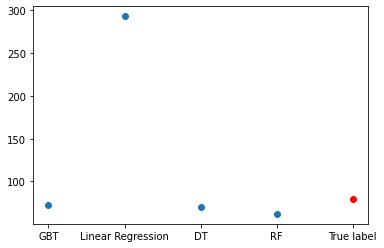

In [64]:
# Scatter plot
plt.scatter(models, res, cmap='hot')
plt.scatter('True label', 79.99, c='red')
plt.show()

## 3. Now see if you can ask users to input their own value for Age and return a predicted value for the cement stength. 

We did not cover this is in the lecture so you'll have to put your thinking cap on. Accepting user input in PySpark works just like it does in traditional Python.
<br>

val = input("Enter your value: ") 

# Reapeat the same steps again but with the age as input value
- To validate, input the same age as the privious example (to make sure you'll get the same prediction)

In [67]:
age = input("Enter the sample's age: ")
inputs = spark.createDataFrame([(540, 0.0, 0.0, 162, 2.5, 1040, 676, int(age))], input_columns)
inputs.limit(5).toPandas()

Enter the sample's age: 28


,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age
0,540,0.0,0.0,162,2.5,1040,676,28


In [68]:
assembler = VectorAssembler(inputCols=input_columns, outputCol="features")
inputs_vec = assembler.transform(inputs).select("features")
inputs_vec.show()

+--------------------+
|            features|
+--------------------+
|[540.0,0.0,0.0,16...|
+--------------------+



In [69]:
test_results=[]
# best_model
predictions = GBT_BestModel.transform(inputs_vec)
predictions.show()
model= 'GBT'
test_results.append([model, int(predictions.collect()[0][1])])

+--------------------+-----------------+
|            features|       prediction|
+--------------------+-----------------+
|[540.0,0.0,0.0,16...|72.20700877684928|
+--------------------+-----------------+



In [70]:
predictions = LR_BestModel.transform(inputs_vec)
predictions.show()
model= 'Linear Regression'
test_results.append([model, int(predictions.collect()[0][1])])

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[540.0,0.0,0.0,16...|293.06224135298424|
+--------------------+------------------+



In [71]:
predictions = DT_BestModel.transform(inputs_vec)
predictions.show()
model= 'DT'
test_results.append([model, int(predictions.collect()[0][1])])

+--------------------+-----------------+
|            features|       prediction|
+--------------------+-----------------+
|[540.0,0.0,0.0,16...|70.08606165105647|
+--------------------+-----------------+



In [72]:
predictions = RF_BestModel.transform(inputs_vec)
predictions.show()
model= 'RF'
test_results.append([model, int(predictions.collect()[0][1])])

+--------------------+-----------------+
|            features|       prediction|
+--------------------+-----------------+
|[540.0,0.0,0.0,16...|62.97111597181506|
+--------------------+-----------------+



In [73]:
test_results = np.array(test_results)
test_results

array([['GBT', '72'],
       ['Linear Regression', '293'],
       ['DT', '70'],
       ['RF', '62']], dtype='<U21')

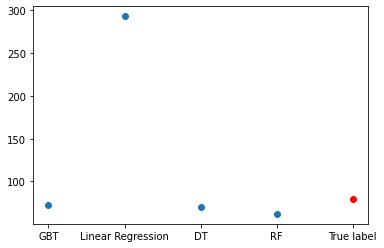

In [74]:
models = test_results[:, 0]
res = test_results[:, 1].astype(int)
# Scatter plot
plt.scatter(models, res, cmap='hot')
plt.scatter('True label', 79.99, c='red')
plt.show()

## 4. Make recommendations of optimal values for cement ingredients (our features)

See if you can find the optimal amount of cement to recommend holding the rest of the values from the previous question constant, assuming that the higher the cement strength value the better. 

In [75]:
df.columns

['cement',
 'slag',
 'flyash',
 'water',
 'superplasticizer',
 'coarseaggregate',
 'fineaggregate',
 'age',
 'csMPa']

## For this problem we may try on some values from a range between min and max values for the cement and test what cement val gets the highest prediction

In [77]:
from pyspark.sql.functions import min, max
df.agg(min('cement'), max('cement')).collect()

[Row(min(cement)=102.0, max(cement)=540.0)]

In [78]:
# max = 
# df.agg({"cement": "max", "cement": "min"})
minn, maxx = df.agg(min('cement'), max('cement')).collect()[0]
np.arange(minn-100, maxx+100, 50)

array([  2.,  52., 102., 152., 202., 252., 302., 352., 402., 452., 502.,
       552., 602.])

In [79]:
preds = []
for cement_val in np.arange(minn-100, maxx+100, 50).astype(int):
  # print(type(int(cement_val)))
  inputs = spark.createDataFrame([(int(cement_val), 0.0, 0.0, 162, 2.5, 1040, 676, age)], input_columns)
  # because age was treated for right skewness
  inputs = inputs.withColumn("age", log("age") + 1)
  inputs_vec = assembler.transform(inputs).select("features")
  predictions = GBT_BestModel.transform(inputs_vec)
  preds.append([int(cement_val), int(predictions.collect()[0][1])])
preds

[[2, 44],
 [52, 44],
 [102, 44],
 [152, 43],
 [202, 43],
 [252, 47],
 [302, 50],
 [352, 72],
 [402, 72],
 [452, 72],
 [502, 72],
 [552, 72],
 [602, 72]]

## Plot the predictions along with the corresponding cement value to indicate the optimal cement val. (which should be at the peak)

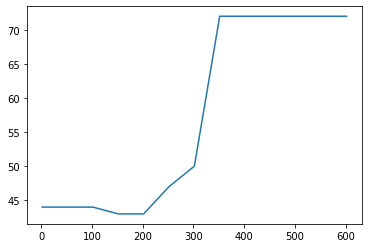

In [81]:
preds = np.array(preds)
cements = preds[:, 0]
res = preds[:, 1].astype(int)
# Scatter plot
sns.lineplot(x=cements, y=res , markers=True, dashes=False)
# plt.scatter('True label', 79.99, c='red')
plt.show()
# plt.plot()

### From the graph, it's shown that the heighest prediction is repeated (the same) starting from cement of **100** and beyond